In [1]:
import scipy.misc
import numpy
import inspect
import traceback

import theano
import theano.tensor as T

from theano.tensor.nnet.abstract_conv import AbstractConv2d_gradInputs
from theano.sandbox.rng_mrg import MRG_RandomStreams
from collections import OrderedDict


In [2]:
def nprand(shape, k):
    return numpy.float32(numpy.random.uniform(-k,k, shape))

def make_param(shape):
    if len(shape) == 1:
        return theano.shared(nprand(shape,0),'b')
    elif len(shape) == 2:
        return theano.shared(nprand(shape, numpy.sqrt(6./sum(shape))), 'W')
    elif len(shape) == 4:
        return theano.shared(nprand(shape, numpy.sqrt(6./(shape[1]+shape[0]*numpy.prod(shape[2:])))), 'W')
    raise ValueError(shape)


def _log(*args):
    if _log.on:
        print " ".join(map(str,args))
_log.on = True



class BlockType:
    def __init__(self, inputs=['input'], outputs=['output']):
        self.inputs = inputs
        self.outputs = outputs
    def __call__(self, f):
        self.f = f
        sign = inspect.getargspec(f)
        kwva = dict((a,default) for a,default in zip(sign.args[-len(sign.defaults):], sign.defaults))
        tb = ''.join(traceback.format_stack())
        
        if not 'block' in kwva:
            raise ValueError('block type',f,'does not have a block argument')
        assert kwva['block'] is None, 'block is a reserved argument and should be None'
        
        def make_block(model,name='name',**kwargs):
            block = Block(self, model, name)
            kwargs['block'] = block
            # replace named inputs with their corresponding blocks
            for inp in self.inputs:
                inp_name = kwargs[inp]
                if inp_name in model.blocks:
                    kwargs[inp] = model.blocks[inp_name]
                    block.inputs.append(inp_name)
                else:
                    raise ValueError("Model's toposort is not sorted properly, '%s' requires '%s'='%s' but '%s' cannot be found or comes later"%(name, inp, kwargs[inp], kwargs[inp]))
            # call actual block maker
            self.f(name,**kwargs)
            return block
        
        def meta_make_block(name='name',**kwargs):
            def f(model):
                try:
                    return make_block(model, name, **kwargs)
                except Exception,e:
                    print 'Block was created:'
                    print tb
                    traceback.print_exc()
                    raise e
            return f
        meta_make_block.func_doc = f.func_doc
        return meta_make_block

class Block:
    def __init__(self, blocktype, model, name):
        self.blocktype = blocktype
        self.model = model
        self.name = name
        self.paramList = []
        self.inputs = []
    def param(self, shape):
        p = make_param(shape)
        p.block = self
        self.paramList.append(p)
        self.model.registerParam(p)
        return p
    def __repr__(self):
        return '<Block %s>'%self.name

class Model:
    def __init__(self):
        self.blocks = {}
        self.params = []
    def registerParam(self, p):
        self.params.append(p)
    def build(self, description):
        # we're going to assume that `description` is already
        # correctly correctly sorted
        self.toposort = []
        for maker in description:
            block = maker(self)
            if block.name in self.blocks:
                raise ValueError("Trying to add block '%s' to Model instance but block name already exists"%block.name)
            self.blocks[block.name] = block
            self.toposort.append(block)

    def apply(self, inputs, partial=False):
        activation_cache = inputs
        for block in self.toposort:
            if block.name in inputs:
                continue

            # check if all inputs are available
            skip = False
            for i in block.inputs:
                if i not in activation_cache:
                    if partial:
                        _log('skipping',block.name,'due to partial evaluation')
                        skip = True
                    else: raise ValueError("I tried using block '%s', needed by '%s', but it is missing (maybe you want partial=True?)"%(i,block.name))
            if skip: continue

            # construct arg list and retrive the block's output
            block_inputs = [activation_cache[i] for i in block.inputs]
            outputs = block.output(*block_inputs)

            if outputs is None: continue # the block does not want to be registered
            
            if not isinstance(outputs, list) and not isinstance(outputs, tuple): outputs = [outputs]
            # fill the activation cache with the block's outputs
            activation_cache[block.name] = outputs[0]
            for output, output_name in zip(outputs, block.blocktype.outputs):
                activation_cache[block.name+'.'+output_name] = output
        return activation_cache




            
@BlockType(inputs=[])
def placeholder(name='placeholder', shape=(None, 32, 32, 3), block=None):
    _log('placeholder', name, shape)
    block.output = lambda: None
    block.output_shape = shape
    
@BlockType(outputs=['output','preact'])
def fc(name='fclayer', input='input', nout=128, act=T.tanh, block=None):
    """Build a fully connected layer
    name -- block name
    input -- input block's name
    nout -- number of outgoing units
    act -- the activation function
    """
    nin = input.output_shape[1]
    W = block.param((nin, nout))
    b = block.param((nout,))
    W.name += name; b.name += name;
    prop = lambda x: (act(T.dot(x,W)+b), T.dot(x,W)+b)
    block.output = prop
    block.output_shape = input.output_shape[0], nout
    _log('fc',name,nin, nout, act, block.output_shape)


@BlockType()
def conv(name='conv',input='input', nout=32, fs=5, act=T.nnet.relu, stride=(1,1),block=None):
    nin = input.output_shape[1]
    W = block.param((nout, nin, fs, fs))
    b = block.param((nout,))
    W.name += name; b.name += name;
    prop = lambda x: act(T.nnet.conv2d(x, W,
                                       filter_shape=W.get_value().shape,
                                       border_mode='half',
                                       subsample=stride)
                         + b.dimshuffle('x',0,'x','x'))
    block.output = prop
    block.output_shape = (input.output_shape[0], nout,
                          input.output_shape[2] / stride[0],
                          input.output_shape[3] / stride[1])
    _log('conv',name,nin,nout,fs,act,stride, block.output_shape)


@BlockType()
def conv_transpose(name='convT',input='input', nout=32, fs=5, act=T.tanh, stride=(1,1),block=None):
    nin = input.output_shape[1]
    W = block.param((nin, nout, fs, fs))
    b = block.param((nout,))
    W.name += name; b.name += name;
    convT = AbstractConv2d_gradInputs(border_mode='half',subsample=stride)
    # not sure what those two last dimensions are supposed to be :(
    prop = lambda x: act(convT(W, x, [x.shape[2]*stride[0], x.shape[3]*stride[1], 1, 1])
                         + b.dimshuffle('x',0,'x','x'))
    block.output = prop
    block.output_shape = (input.output_shape[0], nout,
                          input.output_shape[2] * stride[0],
                          input.output_shape[3] * stride[1])
    _log('convT',name,nin,nout,fs,act,stride, block.output_shape)
                         
@BlockType()
def Lambda(name='lambda', input='input', func=lambda x:x, func_shape=lambda xshape:xshape, block=None):
    block.output = func
    block.output_shape = func_shape(input.output_shape)
    _log('lambda', name, block.output_shape)

def LambdaN(name='lambda*', inputs=['A','B'], func=lambda *x:x, func_shape=lambda *x:x):
    fakekw = dict(('input%d'%i,j) for i,j in enumerate(inputs))
    @BlockType(inputs=fakekw.keys())
    def f(name='name',block=None, **kwargs):
        block.output = func
        block.output_shape = func_shape(*[kwargs[i].output_shape for i in fakekw.keys()])
        _log('lambda*',name,block.output_shape)
        
    return f(name=name, func=func,func_shape=func_shape, **fakekw)
    
@BlockType(inputs=['A','B'])
def concatenate(name='concat', A='A', B='B', axis=1, block=None):
    block.output = lambda a,b:T.concatenate([a,b], axis=axis)
    As = A.output_shape
    Bs = B.output_shape
    new_shape = [0] * len(As)
    assert len(As) == len(Bs), 'A and B must have the same number of dimensions'
    for i,(a,b) in enumerate(zip(As,Bs)):
        if i != axis:
            assert a==b, 'A and B must have the same shape along axis %d, A: %s, B: %s'%(i,As,Bs)
            new_shape[i] = a
        else:
            new_shape[i] = a+b
    block.output_shape = new_shape
    _log('concat', name, axis, As, Bs, block.output_shape)
    
@BlockType()
def image2flat(name='img2flat', input='input', block=None):
    block.output = lambda x:x.reshape([x.shape[0], -1])
    block.output_shape = input.output_shape[0], numpy.prod(input.output_shape[1:])
    _log('image2flat', name, block.output_shape)

@BlockType()
def flat2image(name='flat2img', input='input', shape=(3,32,32), block=None):
    block.output = lambda x:x.reshape([x.shape[0]]+list(shape))
    block.output_shape = [input.output_shape[0]] + list(shape)
    assert numpy.prod(shape) == input.output_shape[1],"image shape does not match this block's input shape"
    _log('flat2image', name, block.output_shape)


@BlockType(inputs=['input','htm1'])
def rnn_core(name='rnn_layer', input='input', htm1='htm1', nhid=32, block=None):
    nin = input.output_shape[-1]
    Wx = block.param((nin, nhid))
    Wh = block.param((nhid, nhid))
    b = block.param((nhid,))
    Wx.name += name; Wh.name += name; b.name += name;
    prop = lambda x,htm1: T.tanh(T.dot(x,Wx)+T.dot(htm1,Wh) + b)
    block.output = prop
    block.output_shape = input.output_shape[0], nhid
    _log('rnn core',name,nin, nhid, block.output_shape)


    
class adam:
    def __init__(self,
                 beta1 = 0.9, beta2 = 0.999, epsilon = 1e-4):
        self.b1 = numpy.float32(beta1)
        self.b2 = numpy.float32(beta2)
        self.eps = numpy.float32(epsilon)

    def __call__(self, params, grads, lr):
        t = theano.shared(numpy.array(2., dtype = 'float32'))
        updates = OrderedDict()
        updates[t] = t + 1

        for param, grad in zip(params, grads):
            last_1_moment = theano.shared(numpy.float32(param.get_value() * 0))
            last_2_moment = theano.shared(numpy.float32(param.get_value() * 0))

            new_last_1_moment = T.cast((numpy.float32(1.) - self.b1) * grad + self.b1 * last_1_moment, 'float32')
            new_last_2_moment = T.cast((numpy.float32(1.) - self.b2) * grad**2 + self.b2 * last_2_moment, 'float32')

            updates[last_1_moment] = new_last_1_moment
            updates[last_2_moment] = new_last_2_moment
            updates[param] = (param - (lr * (new_last_1_moment / (numpy.float32(1.) - self.b1**t)) /
                                      (T.sqrt(new_last_2_moment / (numpy.float32(1.) - self.b2**t)) + self.eps)))

        return list(updates.items())

    
def example():

    # First start with a Model object
    model = Model()
    # then build the blocks in a model
    model.build([
        # think of a placeholder as a T.tensor
        placeholder('input', shape=(None, 28*28)),
        # here we create two fully connected layers
        # the first argument is always the name of the block, it must be unique
        fc('fc1', input='input', nout=128, act=T.nnet.sigmoid),
        # the other arguments depend on the block type
        # generally, `input` is the name of this block's input block
        fc('fc2', input='fc1', nout=10, act=T.nnet.softmax),

        # it's also possible to define lambdas, the downside being you need to specify the shape
        LambdaN('test', inputs=['fc1','fc2'],
                func=lambda x,y:T.concatenate([x,y],axis=0),
                func_shape=lambda x,y:[x[0],y[1]+x[1]])
        # making custom blocks might be a cleaner alternative to lambdas
    ])

    x = T.matrix('x')
    y = T.vector('y')

    # apply the model to x, here {'input':x} means we're attributing x to be the output
    # of the block 'input', but it could be any block, think of it as theano's givens
    forward_pass = model.apply({'input':x})
    # retreive the output of fc2 during the (symbolic) forward pass
    pred = forward_pass['fc2']
    # the previous line retrieves the default output, but a block can have more than one
    # for example the `fc` block has two outputs, 'output' and 'preact' (before the activation)
    preact = forward_pass['fc2.preact']
    # pred is a theano Softmax.0, while preact is `T.dot(x,W) + b`, which is a theano Elemwise{add}.0
    print pred, preact 

    print forward_pass['test']
    
if __name__ == '__main__':
    example()

placeholder input (None, 784)
fc fc1 784 128 sigmoid (None, 128)
fc fc2 128 10 <function softmax at 0x000000000901EC18> (None, 10)
lambda* test [None, 138]
Softmax.0 Elemwise{add,no_inplace}.0
Join.0


In [3]:
import os  

"""
os.environ['THEANO_FLAGS'] = "floatX=float32"   
os.environ['THEANO_FLAGS'] = "device=cpu"  
os.environ['THEANO_FLAGS'] = "force_device=True"   
"""

os.environ['THEANO_FLAGS'] = "device=cpu,force_device=True,floatX=float32"

import time
import numpy
import numpy as np
from numpy.random import randint



import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as pp




import theano
import theano.tensor as T

%matplotlib inline  


In [4]:

class Squares:
    def __init__(self, nsquares=1, size=5, side=2):
        self.nsquares = nsquares
        self.size = size # size of the observation
        self.side = side # size of squares
    @property
    def nactions(self):
        return 4
    def genRandomSample(self):
        """
        get a random (s,a,s') transition from the environment (assuming a uniform policy)
        returns (state, action, next state)
        """
        p_0 = pos = [randint(0,self.size-self.side,2) for i in range(self.nsquares)]
        action = randint(0,self.nactions,self.nsquares)
        delta = [(1,0),(-1,0),(0,1),(0,-1)]
        s_0 = numpy.zeros([self.size]*2, 'float32')
        for i in range(self.nsquares):
            s_0[pos[i][0]:pos[i][0]+self.side,
                pos[i][1]:pos[i][1]+self.side] = 1
        pos = [p+delta[action[i]] for i,p in enumerate(pos)]
        pos = [numpy.minimum(numpy.maximum(p,0),self.size-self.side) for p in pos]
        s_1 = numpy.zeros([self.size]*2, 'float32')
        for i in range(self.nsquares):
            s_1[pos[i][0]:pos[i][0]+self.side,
                pos[i][1]:pos[i][1]+self.side] = 1
        return (s_0.flatten(), action, s_1.flatten(), p_0, pos)



In [5]:
def train(learn, env, niters):
    mbsize = 64
    losses = []
    for i in range(niters):
        s,a,sp,tf,tf1 = map(numpy.float32, zip(*[env.genRandomSample() for j in range(mbsize)]))
        losses.append(learn(s,sp,numpy.int32(a)[:,0]))
    return losses

def extract_features(encoder, policy, env, niters):
    mbsize = 1
    latent_features = []
    real_features = []
    policies = []
    for i in range(niters):
        s,a,sp,tf,tf1 = map(numpy.float32, zip(*[env.genRandomSample() for j in range(mbsize)]))
        real_features.append(tf[0].flatten() / 6. - 1)
        latent_features.append(encoder(s)[0])
        policies.append(policy(s)[0])
    return latent_features, real_features, policies


[ 0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[2]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  

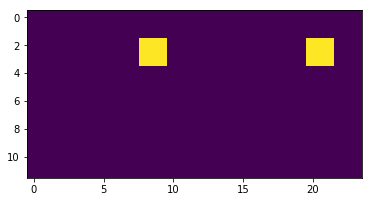

In [90]:
class SquaresNew:
    def __init__(self, nsquares=1, size=5, side=2):
        self.nsquares = nsquares
        self.size = size # size of the observation
        self.side = side # size of squares
    @property
    def nactions(self):
        return 4
    def genRandomSample(self):
        """
        get a random (s,a,s') transition from the environment (assuming a uniform policy)
        returns (state, action, next state)
        """
        p_0 = pos = [randint(0,self.size-self.side,2) for i in range(self.nsquares)]
        action = randint(0,self.nactions,self.nsquares)
        delta = [(1,0),(-1,0),(0,1),(0,-1)]
        s_0 = numpy.zeros([self.size]*2, 'float32')
        for i in range(self.nsquares):
            s_0[pos[i][0]:pos[i][0]+self.side,
                pos[i][1]:pos[i][1]+self.side] = 1
        pos = [p+delta[action[i]] for i,p in enumerate(pos)]
        pos = [numpy.minimum(numpy.maximum(p,0),self.size-self.side) for p in pos]
        s_1 = numpy.zeros([self.size]*2, 'float32')
        for i in range(self.nsquares):
            s_1[pos[i][0]:pos[i][0]+self.side,
                pos[i][1]:pos[i][1]+self.side] = 1
        return (s_0.flatten(), action, s_1.flatten(), p_0, pos)






















env = SquaresNew(1,12,2) 

recons = []
st = env.genRandomSample()

st2 = env.genRandomSample()

recons.append([st[0],st[0]])


pp.imshow(numpy.hstack([recons[-1][0].reshape((env.size,env.size)), recons[-1][1].reshape((env.size,env.size))]), interpolation='none')





print(env.genRandomSample()[0])
print(env.genRandomSample()[1])
print(env.genRandomSample()[2])
print(env.genRandomSample()[3])
print(env.genRandomSample()[4])








In [89]:



env = Squares(1,12,2) 
N_latent = 6 # number of latent ICF
convn = [16,16] # number of hidden conv channels
convfs = 3 # filter size
nhid = 32 # number of fc hidden
rec_factor = 0.1 # factor of the reconstruction loss
lr = theano.shared(numpy.array(0.0005,'float32'))
    
model = Model()
model.build([
    placeholder('s_t', shape=(None, env.size**2)),

    # encoder
    flat2image('s_t_image', input='s_t', shape=(1,env.size,env.size)),
    conv('conv1', input='s_t_image', nout=convn[0], fs=convfs, act=T.nnet.relu, stride=(1,1)),
    conv('conv2', input='conv1',     nout=convn[1], fs=convfs, act=T.nnet.relu, stride=(1,1)),
    image2flat('conv2_flat', input='conv2'),
    fc('h1', input='conv2_flat', nout=nhid, act=T.nnet.relu),
    fc('h', input='h1', nout=N_latent, act=T.tanh),

    # decoder
    conv_transpose('convT2', input='conv2', nout=convn[0], fs=convfs,act=T.nnet.relu,stride=(1,1)),
    conv_transpose('convT1', input='convT2', nout=1, fs=convfs,act=lambda x:x,stride=(1,1)),
        
    # actor policy
    fc('pi_act', input='h1', nout=env.nactions * N_latent, act=lambda x:x),

])

### theano tensors 
st = T.matrix()
stp1 = T.matrix()
at = T.ivector()

    
### apply
fp_st = model.apply({'s_t': st}, partial=True)
fp_stp1 = model.apply({'s_t':stp1}, partial=True)
# features and reconstruction at time t
f_st = fp_st['h']
r_st = fp_st['convT1']

# at time t+1
f_stp1 = fp_stp1['h']
    
# policies
pi_act = T.nnet.softmax(fp_st['pi_act'].reshape((-1, env.nactions))).reshape((-1, N_latent, env.nactions))

# probabilities of the taken actions
prob_act = pi_act[T.arange(st.shape[0]), :, at]


### losses
reconstruction_loss = T.mean((st.flatten()-r_st.flatten())**2)
    
    
def sample_selectivity(f, fp):
    return (f - fp) / (1e-4 + T.sum(T.nnet.relu(f - fp), axis=1)[:, None])

    
sel = sample_selectivity(f_st, f_stp1)
selectivity_of_at = prob_act * sel[:,:N_latent]
act_selectivity_loss = -T.mean(selectivity_of_at)
total_loss = rec_factor * reconstruction_loss + act_selectivity_loss


### theano functions
params = model.params
gradients = T.grad(total_loss, params)
updates = adam()(params, gradients, lr)

learn_func = theano.function([st,stp1,at], [act_selectivity_loss, reconstruction_loss], updates=updates)
encode_func = theano.function([st], f_st)
reconstruct_func = theano.function([st],r_st)
policy_func = theano.function([st], pi_act)


### training
all_losses = []
features = []
recons = []
for epoch in range(20):
    # train
    losses = train(learn_func, env, 500)
    # decay lr
    lr.set_value(numpy.float32(lr.get_value() * 0.99))
    print epoch, map(numpy.mean,zip(*losses))
    all_losses += losses

    # plotting
    latent_features, real_features, policies = extract_features(encode_func, policy_func, env, 200)
    features.append([latent_features, real_features])
        
    ntrue = len(real_features[0])
    nfeat = N_latent
    feat = numpy.concatenate((latent_features,real_features),axis=1).T

    real_features = numpy.float32(real_features).T
    latent_features = numpy.float32(latent_features).T

    # do a linear regression to get the coefficients and plot them
    # to see how the real features correlate with the learned latent features
    slopes = numpy.float32([
        [scipy.stats.linregress(real, lat).slope
        for real in real_features]
        for lat in latent_features])
    magnitudes = numpy.float32([abs(latent_features).mean(axis=1),
                                latent_features.mean(axis=1),
                                latent_features.var(axis=1)])
    # see how well the reconstruction is doing
    st = env.genRandomSample()[0]
    rt = reconstruct_func([st])[0]
    recons.append([st,rt])

    policies_stats = numpy.mean(policies,axis=0)

    # actual plotting
    pp.clf()
    f, axarr = pp.subplots(2,3,figsize=(19,8))
    axarr[0,0].imshow(numpy.hstack([recons[-1][0].reshape((env.size,env.size)),
                                    recons[-1][1].reshape((env.size,env.size))]), interpolation='none')
    slopes_max = max([-slopes.min(), slopes.max()])
    f.colorbar(axarr[1,1].imshow(slopes, interpolation='none', cmap='bwr',vmin=-slopes_max,vmax=slopes_max),
               ax=axarr[1,1])
    f.colorbar(axarr[1,0].imshow(policies_stats, interpolation='none',cmap='YlOrRd'), ax=axarr[1,0])
    f.colorbar(axarr[0,1].imshow(magnitudes, interpolation='none',cmap='YlOrRd'), ax=axarr[0,1])
        
    for i in range(nfeat):
        rf = np.arange(real_features.min(),real_features.max()+1/6.,1./6,'float32')
        lf = numpy.float32([latent_features[i][np.int32(np.round(real_features[0]*12))==j].mean()
                            for j in range(-12,8,2)])
        axarr[0,2].plot(rf, lf)
        indexes = sorted(range(latent_features.shape[1]), key=lambda x:real_features[1][x])
        lf = numpy.float32([latent_features[i][np.int32(np.round(real_features[1]*12))==j].mean()
                            for j in range(-12,8,2)])
        axarr[1,2].plot(rf, lf)
            
    pp.savefig('plots/epoch_%03d.png'%epoch)
    pp.show()
    pp.close()
return features, recons






placeholder s_t (None, 144)
flat2image s_t_image [None, 1, 12, 12]
conv conv1 1 16 3 <function relu at 0x00000000090DFBA8> (1, 1) (None, 16, 12, 12)
conv conv2 16 16 3 <function relu at 0x00000000090DFBA8> (1, 1) (None, 16, 12, 12)
image2flat conv2_flat (None, 2304)
fc h1 2304 32 <function relu at 0x00000000090DFBA8> (None, 32)
fc h 32 6 Elemwise{tanh,no_inplace} (None, 6)
convT convT2 16 16 3 <function relu at 0x00000000090DFBA8> (1, 1) (None, 16, 12, 12)
convT convT1 16 1 3 <function <lambda> at 0x000000000FBE69E8> (1, 1) (None, 1, 12, 12)
fc pi_act 32 24 <function <lambda> at 0x000000000FBE6B38> (None, 24)


KeyboardInterrupt: 